google/vit-base-patch16-224 <br>



# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu124
GPU available: 0


In [3]:
#!nvcc --version

In [4]:
# For data augmentation
from torchvision import transforms, datasets

In [5]:
import transformers

# For Tokenizers
from transformers import ViTImageProcessor, ViTConfig

# For Model
from transformers import ViTModel, ViTForImageClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [6]:
!pip install -q datasets #==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [7]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [8]:
#!pip install -q accelerate==0.21.0

In [9]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [10]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 75.3 MB/s eta 0:00:00


In [11]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [12]:
#!pip install -q av

In [13]:
!pip install -q tensorboard

In [14]:
!pip install -q kaggle

In [15]:
from torch.utils.tensorboard import SummaryWriter

In [16]:
import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import zipfile

import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [18]:
import torch.nn.functional as F

In [19]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import io
import html
import time

# Initialse Globle Variables

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [22]:
gdrive_path = '/content/drive/MyDrive/Kaggle/FaceRecognition'
local_path = '/content/FaceRecognition'
webcam_path = '/content/WebcanData'

In [23]:
BATCH_SIZE = 8
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'google/vit-base-patch16-224'

EMBEDDING_SIZE = 512
print('EMBEDDING_SIZE =',EMBEDDING_SIZE)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 8
BUFFER_SIZE = 64
EMBEDDING_SIZE = 512
Image Dimension = 224 X 224


In [24]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [25]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
seed_everything(42)

# Import Data

In [27]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData


In [28]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(prod_data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [29]:
# Collect all video files
image_paths = []

image_file = glob(os.path.join(prod_data_dir, '*.jpg'))
print(image_file)
image_paths.extend(image_file)

['/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Kaushik_YH.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrien_Brody.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrian_Nastase.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adam_Herbert.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdullah_Ahmad_Badawi.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdel_Nasser_Assidi.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Aaron_Eckhart.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Shreepada.jpg']


In [30]:
print('input path size:', len(image_paths))
print(image_paths)

input path size: 8
['/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Kaushik_YH.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrien_Brody.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrian_Nastase.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adam_Herbert.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdullah_Ahmad_Badawi.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdel_Nasser_Assidi.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Aaron_Eckhart.jpg', '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Shreepada.jpg']


# Capture from webcam

In [31]:
if not os.path.exists(webcam_path):
  os.mkdir(webcam_path)

In [32]:
webcam_image_path = f'{webcam_path}/photo.jpg'

In [33]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [34]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/WebcanData/photo.jpg


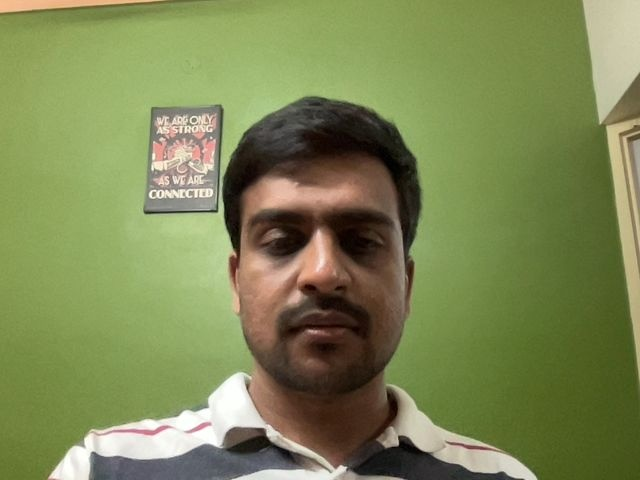

In [35]:
try:
  filename = take_photo(webcam_image_path)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [36]:
[webcam_image_path]

['/content/WebcanData/photo.jpg']

In [ ]:
#prod_webcam_paths = [webcam_image_path] * len(image_paths)

In [ ]:
#prod_webcam_paths

# Create Dataset

In [43]:
image_processor_prod = ViTImageProcessor.from_pretrained(MODEL_TRANSFORMER, attn_implementation="sdpa", torch_dtype=torch.float16)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [44]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx].squeeze(0),
        }
        return item

In [45]:
class CreateDatasetProd():
    def __init__(self, image_processor):
        super().__init__()
        self.image_processor = image_processor
        # Define a transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.ToDtype(torch.uint8, scale=False)
                                ])

    def get_pixels(self, img_paths):
        pixel_values = []
        for path in tqdm(img_paths):
            # Read and process Images
            img = PIL.Image.open(path)
            img = self.transform_prod(img)

            # Scaling the video to ML model's desired format
            img = self.image_processor(img, return_tensors='pt') #, input_data_format='channels_first')

            pixel_values.append(img['pixel_values'].squeeze(0))

            # Force garbage collection
            del img
            gc.collect()

        return pixel_values

    def create_dataset(self, image_paths):

        pixel_values = torch.stack(self.get_pixels(image_paths))

        return CustomDatasetProd(pixel_values = pixel_values)

In [46]:
dataset_prod_obj = CreateDatasetProd(image_processor_prod)

In [47]:
prod_ds = dataset_prod_obj.create_dataset(image_paths)

  0%|          | 0/8 [00:00<?, ?it/s]

In [48]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [49]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape)

torch.Size([8, 3, 224, 224])


In [50]:
webcam_ds = dataset_prod_obj.create_dataset([webcam_image_path])
webcam_dl = DataLoader(webcam_ds, batch_size=BATCH_SIZE)

  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
prod_inputs = next(iter(webcam_dl))
print(prod_inputs['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


# Model testing

In [37]:
hyperparameters = {
    "seed": 42,
    "output_dir_pt": f"{gdrive_path}/vit_pytorch_GPU_4.pt"
}

In [38]:
# Creating NN Layer
class FaceEmbeddingModel(torch.nn.Module):
    def __init__(self, model_name, embedding_size):
        super(FaceEmbeddingModel, self).__init__()
        self.config = ViTConfig.from_pretrained(model_name, id2label=idx_to_label, label2id=label_to_idx, return_dict=True)
        self.backbone = ViTModel.from_pretrained(model_name, config=self.config)  # Load ViT model
        self.fc = torch.nn.Linear(self.backbone.config.hidden_size, embedding_size) # Convert to 512D feature vector

    def forward(self, images):
        x = self.backbone(images).last_hidden_state[:, 0]  # Extract embeddings
        x = self.fc(x)  # Convert to 512D embedding
        return torch.nn.functional.normalize(x)  # Normalize for cosine similarity

In [39]:
# Load the model
model_pretrained = torch.load(hyperparameters['output_dir_pt'], map_location=torch.device('cpu'), weights_only=False)

In [40]:
# Load the model
#model_pretrained = FaceEmbeddingModel(MODEL_TRANSFORMER, EMBEDDING_SIZE)
#model_pretrained.load(torch.load(hyperparameters['output_dir_pt'], weights_only=False, map_location=device))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

In [41]:
# Now we train the model
def prod_function(transformer_model, prod_dl, webcam_dl):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl, acclerated_webcam_dl = accelerator.prepare(transformer_model, prod_dl, webcam_dl)

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    for batch in tqdm(acclerated_webcam_dl):
      img_webcam = batch['pixel_values']
      with torch.no_grad():
          emb_webcam = accelerated_model(img_webcam)

    prod_preds = []

    for batch in tqdm(acclerated_prod_dl):
        img = batch['pixel_values']
        with torch.no_grad():
            emb = accelerated_model(img)

        distance = F.cosine_similarity(emb_webcam, emb)

        prod_preds.append(distance)
    return prod_preds

## Positive prediction

In [52]:
prediction = prod_function(model_pretrained, prod_dl, webcam_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
predictions = torch.cat(prediction, 0).to('cpu')

In [54]:
predictions

tensor([-0.0892,  0.1604,  0.0695,  0.2568,  0.0253,  0.0509,  0.2517,  0.0941])

In [55]:
match_idx = torch.argmin(predictions)
if predictions[match_idx] <= 0.3:
  print('Welcome: ',image_paths[match_idx].split('/')[-1].split('.')[0])
else:
  print("Match not found")

Welcome:  Kaushik_YH


In [56]:
image_paths

['/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Kaushik_YH.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrien_Brody.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adrian_Nastase.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Adam_Herbert.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdullah_Ahmad_Badawi.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Abdel_Nasser_Assidi.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Aaron_Eckhart.jpg',
 '/content/drive/MyDrive/Kaggle/FaceRecognition/ProdData/Shreepada.jpg']

## Negetive Prediction

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/WebcanData/photo.jpg


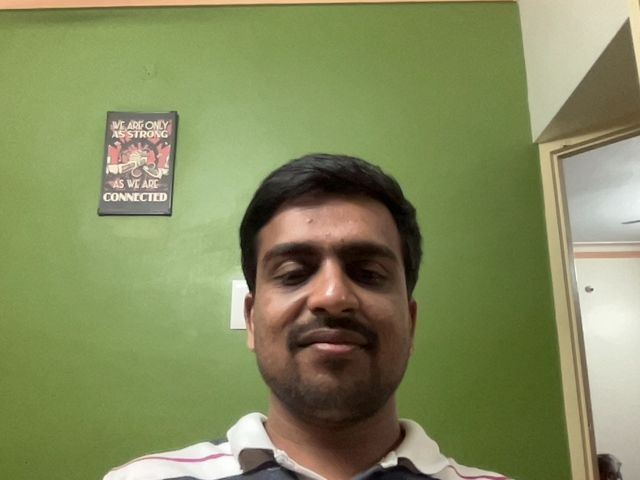

In [75]:
try:
  filename = take_photo(webcam_image_path)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [76]:
webcam_ds = dataset_prod_obj.create_dataset([webcam_image_path])
webcam_dl = DataLoader(webcam_ds, batch_size=BATCH_SIZE)

  0%|          | 0/1 [00:00<?, ?it/s]

In [77]:
prediction = prod_function(model_pretrained, prod_dl, webcam_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [78]:
predictions = torch.cat(prediction, 0).to('cpu')

In [79]:
predictions

tensor([0.0779, 0.1847, 0.1256, 0.1801, 0.0512, 0.1793, 0.1464, 0.1554])

In [80]:
match_idx = torch.argmin(predictions)
if predictions[match_idx] <= 0.1:
  print('Welcome: ',image_paths[match_idx].split('/')[-1].split('.')[0])
else:
  print("Match not found")

Welcome:  Abdullah_Ahmad_Badawi


## Negetive Prediction

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/WebcanData/photo.jpg


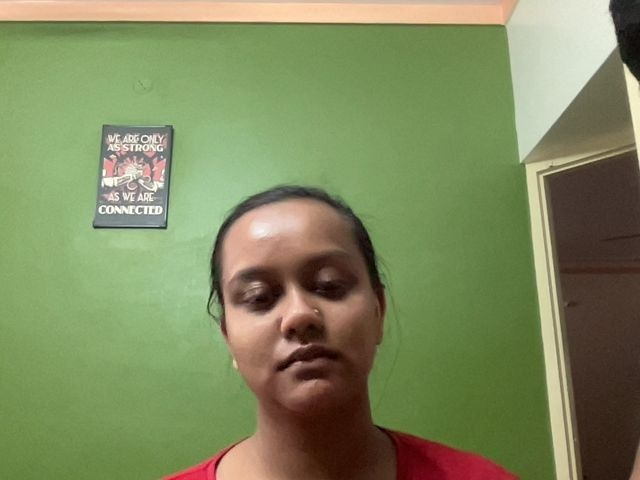

In [ ]:
try:
  filename = take_photo(webcam_image_path)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
prod_webcam_paths = [webcam_image_path] * len(image_paths)
prod_webcam_paths

['/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg',
 '/content/WebcanData/photo.jpg']

In [ ]:
prod_ds = dataset_prod_obj.create_dataset(image_paths, prod_webcam_paths)
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
prediction = prod_function(model_pretrained, prod_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions = torch.cat(prediction, 0).to('cpu')

In [ ]:
predictions

tensor([0.9823, 1.0094, 1.2779, 1.2587, 1.1730, 0.8314, 1.0433, 0.7621])

In [ ]:
match_idx = torch.argmin(predictions)
if predictions[match_idx] <= 0.3:
  print('Welcome: ',image_paths[match_idx].split('/')[-1].split('.')[0])
else:
  print("Match not found")

Match not found
